# Лабораторная работа №6
Выполнила Агеева Алиса М8О-410Б-21

## 1. Выбор начальных условий
данные взяты из https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification

Выбор обусловлен акутальностью распознования спутниковых данных, так как сфера активно развивается и в данное время много где используюстя спутниковые данные: построение карт,в военных целях, при построении дорог, городов, изучении местности и т.д.

In [8]:
# !unzip data.zip


In [6]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
# !pip install thinc==8.3.6

In [ ]:
# !pip install numpy==1.26.4 --force-reinstall


In [ ]:
# !pip install -U numpy scikit-learn

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
# from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
!pip uninstall numpy scipy scikit-learn -y

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.15.2
Uninstalling scipy-1.15.2:
  Successfully uninstalled scipy-1.15.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1


In [28]:
from sklearn.metrics import confusion_matrix, classification_report

In [9]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.device_count())

True
12.4
1


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Метрики

Для этой задачи будем использовать метрики Accuracy и F1-score. Accuracy показывает долю правильно классифицированных изображений среди всех примеров. F1-score, в свою очередь, вычисляется по формуле 2 * (precision * recall) / (precision + recall), что позволяет более глубоко оценить способность модели правильно классифицировать объекты каждого класса.

Эти метрики полезны, поскольку Accuracy дает общее представление о точности модели, а F1-score более детально отражает, как модель справляется с различными классами.

Кроме того, будем строить Confusion Matrix для визуализации того, какие классы модель путает чаще всего. Это поможет выявить слабые места модели, что позволит оптимизировать гиперпараметры или провести дополнительные эксперименты с аугментацией данных.


In [10]:
import torch
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import numpy as np

# Устанавливаем случайное seed
torch.manual_seed(42)
np.random.seed(42)

# Параметры
data_dir = "./data"
batch_size = 32

transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ImageFolder(data_dir, transform=transformations)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Размер Training dataset: {len(train_ds)}")
print(f"Размер Validation dataset: {len(val_ds)}")
print(f"Размер dataset: {len(test_ds)}")


Размер Training dataset: 4504
Размер Validation dataset: 563
Размер dataset: 564


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
def get_classes(data_dir):
    return [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

Классы в датасете: 4 - ['cloudy', 'water', 'green_area', 'desert']


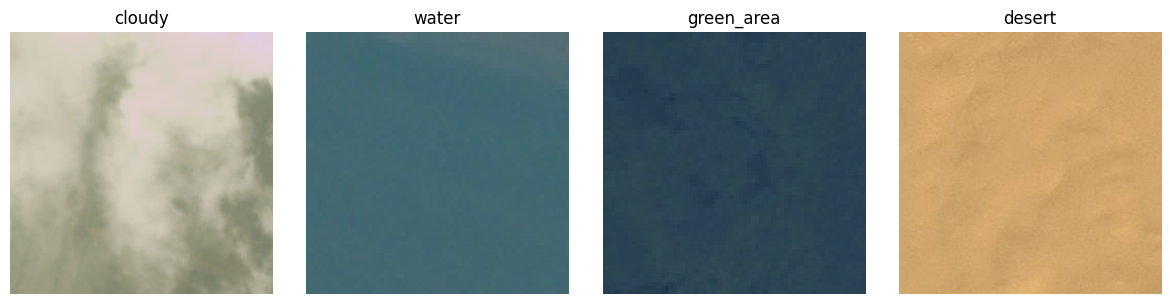

In [ ]:
def sample_class_images(data_dir, classes):
    sample_images, sample_labels = [], []
    for cls in classes:
        img_paths = glob.glob(os.path.join(data_dir, cls, '*.jpg'))
        if img_paths:
            sample_images.append(random.choice(img_paths))
            sample_labels.append(cls)
    return sample_images, sample_labels

def plot_sample_images(image_paths, labels):
    n = len(image_paths)
    plt.figure(figsize=(3 * n, 3))
    for i, (path, label) in enumerate(zip(image_paths, labels)):
        plt.subplot(1, n, i + 1)
        img = mpimg.imread(path)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

data_dir = './data'
classes = get_classes(data_dir)
print(f"Классы в датасете: {len(classes)} - {classes}")

sample_images, sample_labels = sample_class_images(data_dir, classes)
plot_sample_images(sample_images, sample_labels)


Для удобства зададим красный хитмап

In [12]:
def classification_report_model(model, loader, device, class_names, name="Model"):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Печать отчета по классификации
    print(f"\nКлассификационный отчет для: {name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Вычисление и отображение матрицы ошибок
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap='Reds')
    plt.title(f'Confusion Matrix: {name}')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.show()


## Создание бейзлайна и оценка качества


## Resnet

In [ ]:
!pip show torch torchvision

Name: torch
Version: 2.7.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-cufile-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, peft, sentence-transformers, timm, torchvision
---
Name: torchvision
Version: 0.22.0
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.11/dist-packages
Requ

In [ ]:
from torchvision import models

model_resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

batch_size = 32
epochs = 4
learning_rate = 1e-3

def initialize_resnet(model, num_classes, device):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model.to(device)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    return running_loss, acc

def evaluate(model, loader, criterion, device):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    return val_loss, acc

# Инициализация модели
model_resnet = initialize_resnet(model_resnet, len(dataset.classes), device)

# функци потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-3)

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model_resnet, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model_resnet, val_loader, criterion, device)

    print(f"""Эпохи {epoch+1}/{epochs}: Train Loss: {train_loss:.4f} ||  Train Acc: {train_acc:.2f}% || Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%""")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Эпохи 1/4: Train Loss: 17.9303 ||  Train Acc: 96.16% || Val Loss: 8.8010 Val Acc: 85.08%
Эпохи 2/4: Train Loss: 14.1201 ||  Train Acc: 97.09% || Val Loss: 5.9796 Val Acc: 79.04%
Эпохи 3/4: Train Loss: 9.9660 ||  Train Acc: 97.78% || Val Loss: 26.8410 Val Acc: 86.15%
Эпохи 4/4: Train Loss: 6.3776 ||  Train Acc: 98.65% || Val Loss: 9.7077 Val Acc: 79.57%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Классификационный отчет для: Resnet:
              precision    recall  f1-score   support

      cloudy       0.57      1.00      0.72       147
       water       1.00      0.29      0.45       133
  green_area       0.98      0.99      0.99       151
      desert       1.00      0.85      0.92       132

    accuracy                           0.80       563
   macro avg       0.89      0.78      0.77       563
weighted avg       0.88      0.80      0.78       563



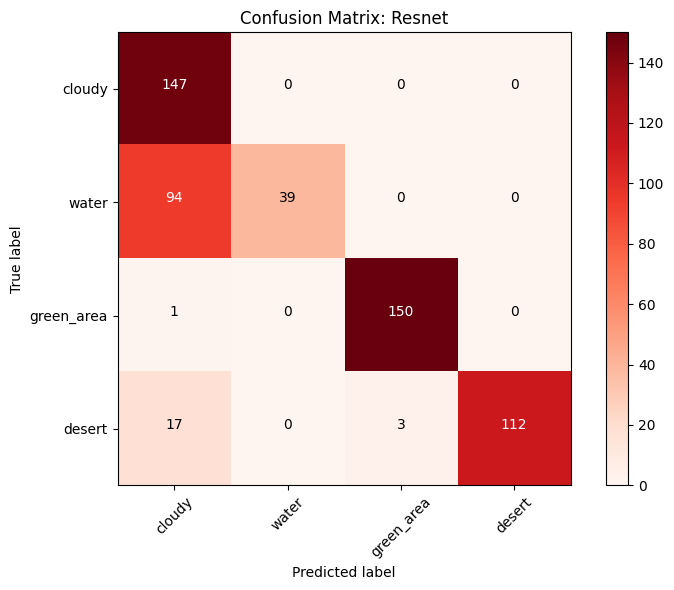

In [ ]:
data_dir = './data'
classes = get_classes(data_dir)
classification_report_model(model_resnet, val_loader, device, classes, name="Resnet")

## ViT

In [ ]:
class_names = dataset.classes
class_names

['cloudy', 'desert', 'green_area', 'water']

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

batch_size = 32
epochs = 4
learning_rate = 1e-3

def initialize_vit(num_classes, device):
    weights = ViT_B_16_Weights.DEFAULT
    model = vit_b_16(weights=weights)
    for param in model.parameters():
        param.requires_grad = True

    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)
    return model.to(device)

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss, accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return val_loss, accuracy

# Инициализация модели
model_vit = initialize_vit(num_classes=len(class_names), device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vit.parameters(), lr=learning_rate)

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model_vit, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model_vit, val_loader, criterion, device)

    print(f"""Эпохи {epoch+1}/{epochs}: Train Loss: {train_loss:.4f} ||  Train Acc: {train_acc:.2f}% || Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%""")


Эпохи 1/4: Train Loss: 197.7073 ||  Train Acc: 36.83% || Val Loss: 14.7841 Val Acc: 46.71%
Эпохи 2/4: Train Loss: 87.7320 ||  Train Acc: 65.43% || Val Loss: 8.4534 Val Acc: 82.95%
Эпохи 3/4: Train Loss: 84.9580 ||  Train Acc: 69.96% || Val Loss: 10.7892 Val Acc: 60.57%
Эпохи 4/4: Train Loss: 70.8711 ||  Train Acc: 71.89% || Val Loss: 8.9728 Val Acc: 66.61%


**Точность на обучающей выборке Train Acc увеличилась, так что если увеличить количество эпох можно в теории добиться более хороших результатов Val Acc**


Классификационный отчет для: ViT:
              precision    recall  f1-score   support

      cloudy       0.93      0.81      0.87       147
       water       0.82      0.95      0.89       133
  green_area       0.00      0.00      0.00       151
      desert       0.46      0.98      0.62       132

    accuracy                           0.67       563
   macro avg       0.55      0.69      0.59       563
weighted avg       0.55      0.67      0.58       563



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


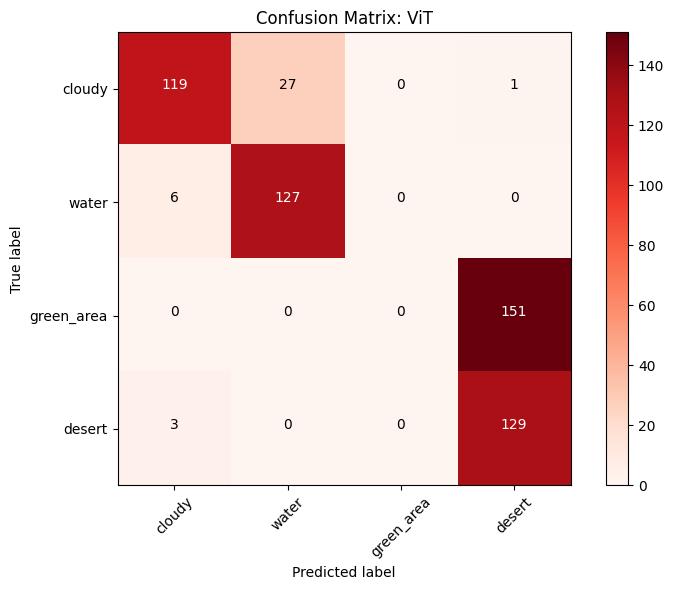

In [ ]:
data_dir = './data'
classes = get_classes(data_dir)
classification_report_model(model_vit, val_loader, device, classes, name="ViT")

### Выводы
В целом 0 ResNet показывает неплохие результаты, а ViT путает леса с пустыней. В обоих случаях наблюдается переобучение, несмотря на то, что точность обучения имеет тендецию роста. Лучших значений Resnet и Vit достигали в 86% и 82% соответсвенно, но делали это не в последней эпохе

# Улучшение бейзлайна

# ResNet

In [14]:
from torch.optim import lr_scheduler

In [ ]:
improved_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.4], [0.23, 0.2, 0.22])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.499, 0.431, 0.5], [0.3, 0.2, 0.22])
    ])
}

In [ ]:
improved_transforms_2 = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.4, 0.4, 0.4])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.45, 0.5], [0.3, 0.2, 0.5])
    ])
}

In [ ]:
batch_size = 16
epochs = 10
learning_rate = 1e-3

In [ ]:
train_ds.dataset.transform = improved_transforms['train']
val_ds.dataset.transform = improved_transforms['val']
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Вместо использования фиксированного learning_rate, можно использовать планировщик (learning rate scheduler) для динамической корректировки скорости обучения, что помогает модели обучаться более стабильно и быстрее

In [ ]:

def create_resnet_model(class_names, device, learning_rate):
    model_resnet = models.resnet18(pretrained=True)
    num_ftrs = model_resnet.fc.in_features
    model_resnet.fc = nn.Linear(num_ftrs, len(class_names))
    model_resnet = model_resnet.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_resnet.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    return model_resnet, criterion, optimizer, scheduler

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    return running_loss, train_acc

def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_acc = 100 * val_correct / val_total
    return val_loss, val_acc

def train_model(train_loader, val_loader, epochs, device, learning_rate, class_names):
    model_resnet, criterion, optimizer, scheduler = create_resnet_model(class_names, device, learning_rate)

    for epoch in range(epochs):
        running_loss, train_acc = train_one_epoch(model_resnet, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_model(model_resnet, val_loader, criterion, device)

        print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        scheduler.step()

train_model(train_loader, val_loader, epochs, device, learning_rate, class_names)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1/9] Train Loss: 120.4268, Train Acc: 68.52%, Val Loss: 14.7432, Val Acc: 69.45%
[Epoch 2/9] Train Loss: 79.0012, Train Acc: 79.11%, Val Loss: 10.5307, Val Acc: 71.76%
[Epoch 3/9] Train Loss: 63.0512, Train Acc: 84.08%, Val Loss: 10.8742, Val Acc: 79.75%
[Epoch 4/9] Train Loss: 51.2935, Train Acc: 86.21%, Val Loss: 12.3321, Val Acc: 75.84%
[Epoch 5/9] Train Loss: 69.3856, Train Acc: 82.28%, Val Loss: 5.6546, Val Acc: 85.26%
[Epoch 6/9] Train Loss: 53.7856, Train Acc: 85.81%, Val Loss: 4.3396, Val Acc: 91.83%
[Epoch 7/9] Train Loss: 45.7010, Train Acc: 87.48%, Val Loss: 28.0852, Val Acc: 68.21%
[Epoch 8/9] Train Loss: 29.0687, Train Acc: 92.85%, Val Loss: 36.2438, Val Acc: 79.04%
[Epoch 9/9] Train Loss: 24.6356, Train Acc: 93.83%, Val Loss: 16.2907, Val Acc: 75.67%


In [ ]:
train_ds.dataset.transform = improved_transforms_2['train']
val_ds.dataset.transform = improved_transforms_2['val']
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

Видно, что модель переобучилась, достигнув в максимуме 91 % в val Acc. Попробую поиграться с настройками и увеличить количество эпох


In [ ]:

def create_resnet_model(class_names, device, learning_rate):
    model_resnet = models.resnet18(pretrained=True)
    num_ftrs = model_resnet.fc.in_features
    model_resnet.fc = nn.Linear(num_ftrs, len(class_names))
    model_resnet = model_resnet.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_resnet.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    return model_resnet, criterion, optimizer, scheduler

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    return running_loss, train_acc

def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_acc = 100 * val_correct / val_total
    return val_loss, val_acc

def train_model(train_loader, val_loader, epochs, device, learning_rate, class_names):
    model_resnet, criterion, optimizer, scheduler = create_resnet_model(class_names, device, learning_rate)

    for epoch in range(epochs):
        running_loss, train_acc = train_one_epoch(model_resnet, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_model(model_resnet, val_loader, criterion, device)

        print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        scheduler.step()

train_model(train_loader, val_loader, epochs, device, learning_rate, class_names)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the wo

[Epoch 1/10] Train Loss: 28.1456, Train Acc: 93.47%, Val Loss: 9.3491, Val Acc: 78.51%
[Epoch 2/10] Train Loss: 14.0082, Train Acc: 97.02%, Val Loss: 2.8830, Val Acc: 95.74%
[Epoch 3/10] Train Loss: 14.3771, Train Acc: 96.56%, Val Loss: 3.5118, Val Acc: 93.25%
[Epoch 4/10] Train Loss: 7.2970, Train Acc: 98.07%, Val Loss: 16.5460, Val Acc: 76.55%
[Epoch 5/10] Train Loss: 8.0568, Train Acc: 98.45%, Val Loss: 14.6383, Val Acc: 76.73%
[Epoch 6/10] Train Loss: 8.4331, Train Acc: 97.67%, Val Loss: 1.7856, Val Acc: 96.27%
[Epoch 7/10] Train Loss: 8.1147, Train Acc: 98.07%, Val Loss: 1.3005, Val Acc: 97.87%
[Epoch 8/10] Train Loss: 2.9581, Train Acc: 99.38%, Val Loss: 0.0902, Val Acc: 100.00%
[Epoch 9/10] Train Loss: 1.5412, Train Acc: 99.62%, Val Loss: 0.0781, Val Acc: 100.00%
[Epoch 10/10] Train Loss: 1.1627, Train Acc: 99.78%, Val Loss: 0.0673, Val Acc: 100.00%


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Классификационный отчет для: ResNet Improve:
              precision    recall  f1-score   support

      cloudy       1.00      0.93      0.96       147
       water       1.00      1.00      1.00       133
  green_area       1.00      0.79      0.89       151
      desert       0.76      1.00      0.87       132

    accuracy                           0.93       563
   macro avg       0.94      0.93      0.93       563
weighted avg       0.94      0.93      0.93       563



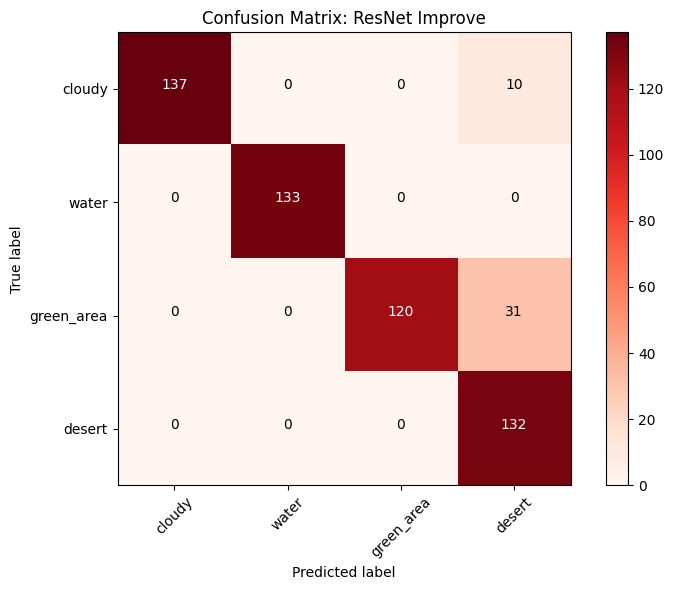

In [ ]:
data_dir = './data'
classes = get_classes(data_dir)
classification_report_model(model_resnet, val_loader, device, classes, name="ResNet Improve")

# Vit

In [ ]:
improved_transforms_2 = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.4, 0.4, 0.4])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.45, 0.5], [0.3, 0.2, 0.5])
    ])
}
batch_size = 16
epochs = 7
learning_rate = 1e-3
train_ds.dataset.transform = improved_transforms_2['train']
val_ds.dataset.transform = improved_transforms_2['val']
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn

def create_vit_model(class_names, device, learning_rate):
    model_vit = models.vit_b_16(pretrained=True)
    num_ftrs = model_vit.heads.head.in_features
    model_vit.heads.head = nn.Linear(num_ftrs, len(class_names))

    model_vit = model_vit.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_vit.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    return model_vit, criterion, optimizer, scheduler

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    return running_loss, train_acc

def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_acc = 100 * val_correct / val_total
    return val_loss, val_acc

def train_model(train_loader, val_loader, epochs, device, learning_rate, class_names):
    model_vit, criterion, optimizer, scheduler = create_vit_model(class_names, device, learning_rate)

    for epoch in range(epochs):
        running_loss, train_acc = train_one_epoch(model_vit, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_model(model_vit, val_loader, criterion, device)
        print(f"Эпохи {epoch+1}/{epochs}, "
          f"Train Loss: {running_loss:.4f} || Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f} || Val Acc: {val_acc:.2f}%")
        scheduler.step()

train_model(train_loader, val_loader, epochs, device, learning_rate, class_names)

Эпохи 1/7, Train Loss: 164.2448 || Train Acc: 68.83%, Val Loss: 16.8834 || Val Acc: 69.45%
Эпохи 2/7, Train Loss: 117.8965 || Train Acc: 78.57%, Val Loss: 14.0754 || Val Acc: 79.57%
Эпохи 3/7, Train Loss: 111.4279 || Train Acc: 80.08%, Val Loss: 14.3077 || Val Acc: 82.24%
Эпохи 4/7, Train Loss: 112.1868 || Train Acc: 81.33%, Val Loss: 11.5311 || Val Acc: 85.26%
Эпохи 5/7, Train Loss: 96.6012 || Train Acc: 84.44%, Val Loss: 16.2206 || Val Acc: 73.53%
Эпохи 6/7, Train Loss: 97.7081 || Train Acc: 83.61%, Val Loss: 8.4116 || Val Acc: 93.07%
Эпохи 7/7, Train Loss: 120.8162 || Train Acc: 78.93%, Val Loss: 11.5652 || Val Acc: 83.30%


In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sat May 10 01:27:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P0             30W /   70W |    9792MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

['cloudy', 'water', 'green_area', 'desert']

Классификационный отчет для: ViT Improve:
              precision    recall  f1-score   support

      cloudy       0.98      0.97      0.98       147
       water       0.98      0.98      0.98       133
  green_area       0.73      0.67      0.70       151
      desert       0.65      0.71      0.68       132

    accuracy                           0.83       563
   macro avg       0.83      0.83      0.83       563
weighted avg       0.84      0.83      0.83       563



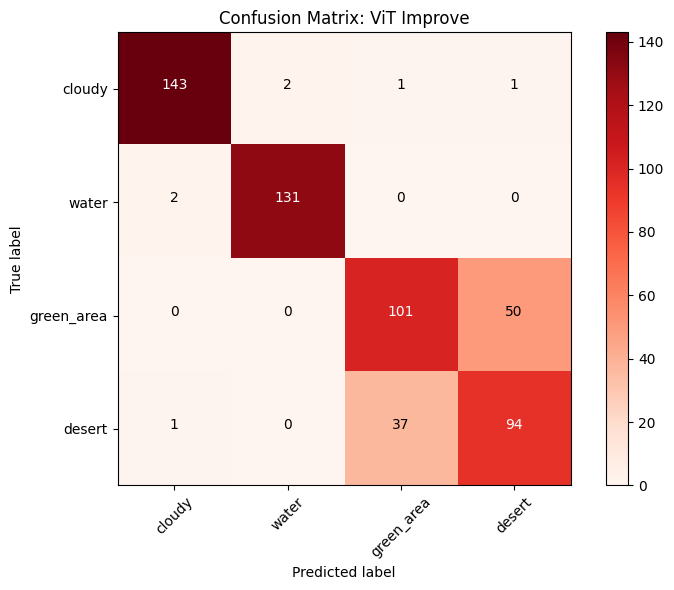

In [ ]:
data_dir = './data'
classes = get_classes(data_dir)
print(classes)
classification_report_model(model_vit, val_loader, device, classes, name="ViT Improve")

##Выводы
Как видно из представленных хитмапов матриц, при улучшении бейзлайна и ResNet и VIt начали значительно лучше классифицировать изображения, особенно хорошие результаты показал ResNet, имея точность на тестовой выборке val acc 100%на последних нескольких эпохах. ViT после улучшения тоже начал справляться лучше, чем до этого.
Таким образом, были достигнуты улучшения результатов при улучшеним бейзлайна.

# Имплементация алгоритма машинного обучения

## CNN

Сначала создам модель CustomCNN, которая представляет собой сверточную нейронную сеть (CNN), предназначенную для классификации изображений. Модель состоит из нескольких блоков свертки (9), за которыми следуют полносвязные слои для предсказания классов.

In [ ]:
torch.manual_seed(43)
np.random.seed(41)


#  Параметры обучения
batch_size = 16
epochs = 5
learning_rate = 1e-3

def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, last_block=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels)
    ]
    if not last_block:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.features = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 64),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 512, last_block=True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def prepare_data(data_dir):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = ImageFolder(data_dir, transform=transform)
    class_names = dataset.classes

    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader, class_names

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f'Эпоха {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss, val_acc = evaluate_model(model, criterion, val_loader)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Эпохи {epoch+1}/{epochs}: '
              f'Train Loss: {train_loss:.4f} || Acc: {train_acc:.2f}% || '
              f'Val Loss: {val_loss:.4f} || Acc: {val_acc:.2f}%')

    return history

def evaluate_model(model, criterion, data_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


data_dir = "./data"
train_loader, val_loader, test_loader, class_names = prepare_data(data_dir)

model = CustomCNN(num_classes=len(class_names)).to(device)
print(model)

CustomCNN(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0

Epoch 1/5: 100%|██████████| 282/282 [00:13<00:00, 20.70it/s]


Эпохи 1/5: Train Loss: 0.5335 || Acc: 80.97% || Val Loss: 0.2827 || Acc: 88.99%


Epoch 2/5: 100%|██████████| 282/282 [00:13<00:00, 20.27it/s]


Эпохи 2/5: Train Loss: 0.4206 || Acc: 84.44% || Val Loss: 0.2190 || Acc: 91.30%


Epoch 3/5: 100%|██████████| 282/282 [00:13<00:00, 20.88it/s]


Эпохи 3/5: Train Loss: 0.3912 || Acc: 84.57% || Val Loss: 0.4051 || Acc: 83.30%


Epoch 4/5: 100%|██████████| 282/282 [00:13<00:00, 20.27it/s]


Эпохи 4/5: Train Loss: 0.3971 || Acc: 84.59% || Val Loss: 0.4261 || Acc: 83.30%


Epoch 5/5: 100%|██████████| 282/282 [00:13<00:00, 21.07it/s]


Эпохи 5/5: Train Loss: 0.3757 || Acc: 86.21% || Val Loss: 0.3303 || Acc: 85.61%
\Финальная точность: 86.52%


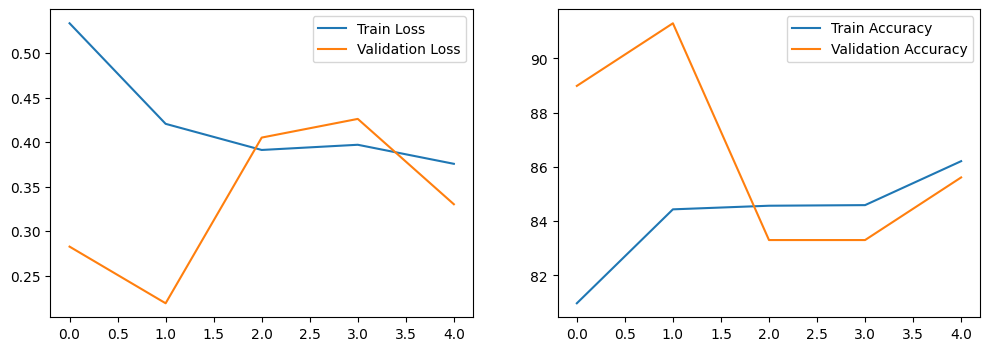

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение
history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs)
test_loss, test_acc = evaluate_model(model, criterion, test_loader)

print(f'\Финальная точность: {test_acc:.2f}%')
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.show()


Классификационный отчет для: Моя CNN:
              precision    recall  f1-score   support

      cloudy       0.00      0.00      0.00      1177
       water       0.00      0.00      0.00       903
  green_area       0.27      1.00      0.43      1222
      desert       0.00      0.00      0.00      1202

    accuracy                           0.27      4504
   macro avg       0.07      0.25      0.11      4504
weighted avg       0.07      0.27      0.12      4504



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


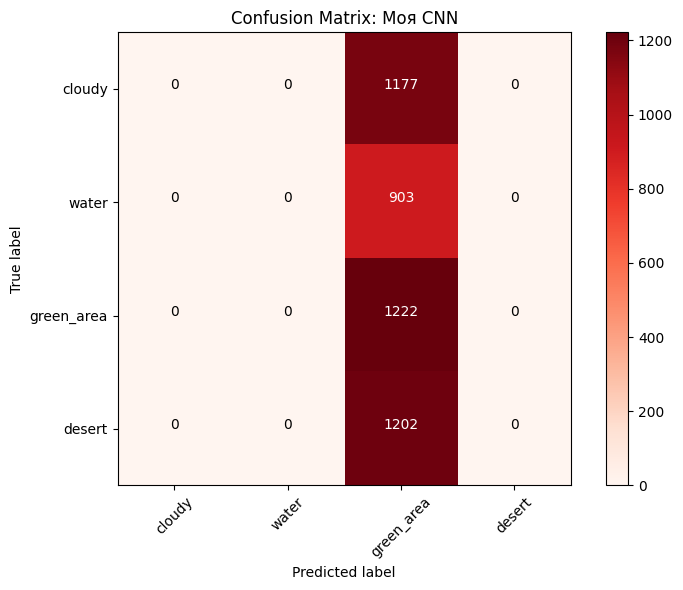

In [ ]:
classification_report_model(model, train_loader, device, classes, "Моя CNN")

### Улучшаем бейслайн

используется лучшая подготовка датасета и улучшенное обучение модели. Одним из методов будет сохранение лучшего
показателя на обучении

In [ ]:
def prepare_data(data_dir, batch_size=16, img_size=224):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.1),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))], p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    ])

    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    full_dataset = ImageFolder(data_dir, transform=test_transform)
    class_names = full_dataset.classes
    train_size = int(0.8 * len(full_dataset))
    val_size = int(0.1 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size

    train_ds, val_ds, test_ds = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_ds.dataset.transform = train_transform

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        drop_last=True
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    def check_distribution(dataset, name):
        counts = torch.zeros(len(class_names))
        for _, label in dataset:
            counts[label] += 1
        print(f"\n{class_names}")
        print(f"{name} распределение: {counts.tolist()}")

    check_distribution(train_ds, "Train")
    check_distribution(val_ds, "Val")
    check_distribution(test_ds, "Test")

    return train_loader, val_loader, test_loader, class_names

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



['cloudy', 'desert', 'green_area', 'water']
Train распределение: [1201.0, 888.0, 1197.0, 1218.0]

['cloudy', 'desert', 'green_area', 'water']
Val распределение: [147.0, 133.0, 151.0, 132.0]

['cloudy', 'desert', 'green_area', 'water']
Test распределение: [152.0, 110.0, 152.0, 150.0]
CustomCNN(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_si

Эпоха 1/5: 100%|██████████| 281/281 [00:34<00:00,  8.26it/s]


Эпохи 1/5: Train Loss: 0.6736 || Acc: 69.40% || Val Loss: 0.4784 || Acc: 75.31%


Эпоха 2/5: 100%|██████████| 281/281 [00:33<00:00,  8.33it/s]


Эпохи 2/5: Train Loss: 0.5455 || Acc: 74.96% || Val Loss: 0.4939 || Acc: 74.78%


Эпоха 3/5: 100%|██████████| 281/281 [00:35<00:00,  8.00it/s]


Эпохи 3/5: Train Loss: 0.5196 || Acc: 77.51% || Val Loss: 0.4549 || Acc: 76.73%


Эпоха 4/5: 100%|██████████| 281/281 [00:33<00:00,  8.43it/s]


Эпохи 4/5: Train Loss: 0.5208 || Acc: 77.20% || Val Loss: 0.4374 || Acc: 79.04%


Эпоха 5/5: 100%|██████████| 281/281 [00:33<00:00,  8.45it/s]


Эпохи 5/5: Train Loss: 0.4868 || Acc: 79.29% || Val Loss: 0.4163 || Acc: 82.95%
\Финальная точность: 82.45%


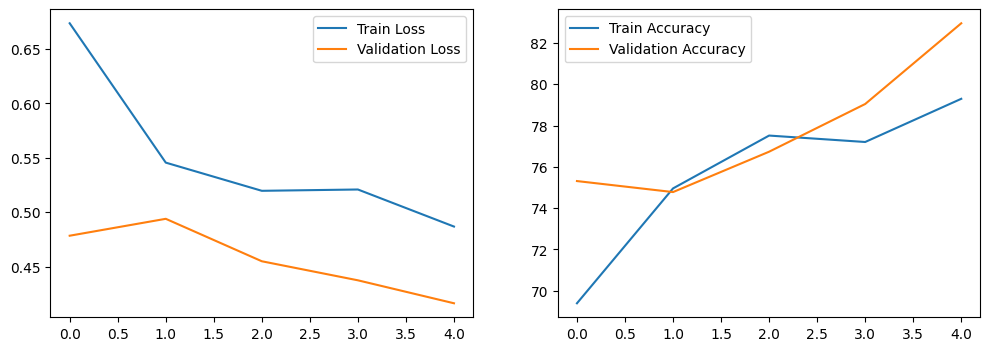

In [ ]:
data_dir = "./data"
train_loader, val_loader, test_loader, class_names = prepare_data(data_dir)

model = CustomCNN(num_classes=len(class_names)).to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение
history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs)
test_loss, test_acc = evaluate_model(model, criterion, test_loader)

print(f'\Финальная точность: {test_acc:.2f}%')
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.show()


Классификационный отчет для: Моя Улучшенная CNN:
              precision    recall  f1-score   support

      cloudy       0.95      0.89      0.92      1198
       water       0.89      0.97      0.93       885
  green_area       0.69      0.96      0.80      1196
      desert       0.92      0.56      0.70      1217

    accuracy                           0.84      4496
   macro avg       0.86      0.85      0.84      4496
weighted avg       0.86      0.84      0.83      4496



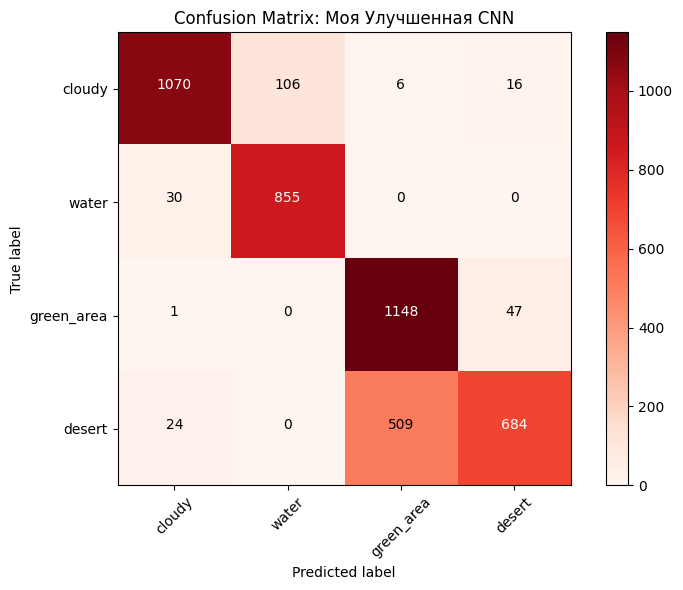

In [ ]:
classification_report_model(model, train_loader, device, classes, "Моя Улучшенная CNN")

Для Cnn виден сильный прирост в качестве классификации после улучшения бейслайна. Это заметно и по графикам потерь


## Трансформер
В данной модели будут 2 слоя внимания (по одному на каждый трансформерный блок) и 1 слой Conv2d

In [ ]:
import torch
import torch.nn as nn
from einops import rearrange

class CustomViT(nn.Module):
    def __init__(self, num_classes=6, image_size=224, patch_size=16, dim=128):
        super().__init__()
        self.patch_embed = nn.Conv2d(
            in_channels=3,
            out_channels=dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        num_patches = (image_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=dim,
                nhead=4,
                dim_feedforward=dim*4,
                dropout=0.1
            ),
            num_layers=2
        )

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes))

    def forward(self, x):
        x = self.patch_embed(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        x = self.transformer(x)
        return self.head(x[:, 0])

In [ ]:
def prepare_data(data_dir, batch_size=16):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(data_dir, transform=transform)
    class_names = dataset.classes
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)
    return train_loader, val_loader, test_loader, class_names

In [ ]:
def train(model, train_loader, val_loader, epochs=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=3e-4)

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        val_loss, val_correct = 0.0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        print(f"Эпоха {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss/len(train_loader):.4f} || "
              f"Train Acc: {100*correct/len(train_loader.dataset):.2f}% || "
              f"Val Loss: {val_loss/len(val_loader):.4f} || "
              f"Val Acc: {100*val_correct/len(val_loader.dataset):.2f}%")

data_dir = "./data"
batch_size = 16
epochs = 3

train_loader, val_loader, test_loader, class_names = prepare_data(data_dir, batch_size)
model = CustomViT(num_classes=len(class_names))
train(model, train_loader, val_loader, epochs)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Эпоха 1/3: Train Loss: 1.4066 || Train Acc: 26.20% || Val Loss: 1.3789 || Val Acc: 29.31%
Эпоха 2/3: Train Loss: 1.3934 || Train Acc: 26.38% || Val Loss: 1.3932 || Val Acc: 29.31%
Эпоха 3/3: Train Loss: 1.3967 || Train Acc: 25.71% || Val Loss: 1.3810 || Val Acc: 29.31%



Классификационный отчет для: Мой ViT:
              precision    recall  f1-score   support

       water       0.00      0.00      0.00      1216
      desert       0.00      0.00      0.00       907
      cloudy       0.00      0.00      0.00      1199
  green_area       0.26      1.00      0.42      1182

    accuracy                           0.26      4504
   macro avg       0.07      0.25      0.10      4504
weighted avg       0.07      0.26      0.11      4504



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


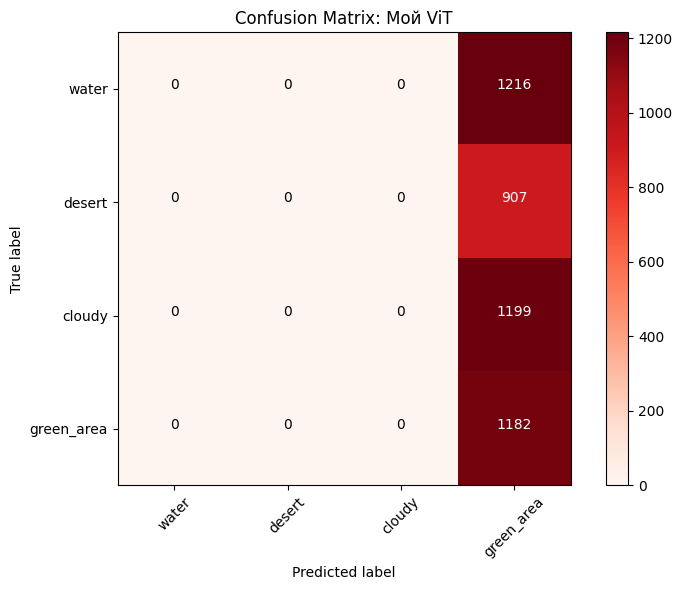

In [ ]:
classes = get_classes(data_dir)
classification_report_model(model, train_loader, device, classes, "Мой ViT")

### Улучшаем бейслайн
используется лучшая подготовка датасета и улучшенное обучение модели. Одним из методов будет сохранение лучшего показателя на обучении

In [31]:
class BetterViT(nn.Module):
    def __init__(self, num_classes=6, image_size=224, patch_size=16, dim=128, depth=6, heads=8):
        super().__init__()
        self.patch_embed = nn.Sequential(
            nn.Conv2d(3, dim//2, kernel_size=7, stride=2, padding=3),
            nn.GELU(),
            nn.Conv2d(dim//2, dim, kernel_size=patch_size, stride=patch_size))

        num_patches = ((image_size // 2) // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = nn.Sequential(*[
            nn.TransformerEncoderLayer(
                d_model=dim,
                nhead=heads,
                dim_feedforward=dim*4,
                dropout=0.1,
                activation='gelu'
            )
            for _ in range(depth)
        ])

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim*2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(dim*2, num_classes))

    def forward(self, x):
        x = self.patch_embed(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        x = self.transformer(x)
        return self.head(x[:, 0])

In [17]:
def prepare_data_better(data_dir, batch_size=16, img_size=224):
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.1),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))], p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    ])

    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    full_dataset = ImageFolder(data_dir, transform=test_transform)
    class_names = full_dataset.classes
    train_size = int(0.8 * len(full_dataset))
    val_size = int(0.1 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size

    train_ds, val_ds, test_ds = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_ds.dataset.transform = train_transform

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        drop_last=True
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    def check_distribution(dataset, name):
        counts = torch.zeros(len(class_names))
        for _, label in dataset:
            counts[label] += 1
        print(f"\n{class_names}")
        print(f"{name} распределение: {counts.tolist()}")

    check_distribution(train_ds, "Train")
    check_distribution(val_ds, "Val")
    check_distribution(test_ds, "Test")

    return train_loader, val_loader, test_loader, class_names

In [18]:
def train_better(model, train_loader, val_loader, epochs=6):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-1)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0.0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
        val_acc = evaluate_simple(model, val_loader, device)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

        print(f"Эпоха {epoch+1}/{epochs}: "
              f"Потери: {train_loss/len(train_loader):.4f} | "
              f"Точность: {100*correct/len(train_loader.dataset):.1f}% | "
              f"Валидация: {val_acc:.1f}%")
    model.load_state_dict(torch.load("best_model.pth"))
    return model

def evaluate_simple(model, loader, device):
    model.eval()
    correct = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()

    return 100 * correct / len(loader.dataset)

In [25]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from einops import rearrange
import numpy as np

In [26]:
data_dir = "./data"
batch_size = 16
epochs = 6
class_names = get_classes(data_dir)

model = BetterViT(num_classes=len(class_names))
train_loader, val_loader, test_loader, class_names = prepare_data_better(data_dir, batch_size)
trained_model = train_better(model, train_loader, val_loader, epochs=6)


['cloudy', 'desert', 'green_area', 'water']
Train распределение: [1201.0, 888.0, 1197.0, 1218.0]

['cloudy', 'desert', 'green_area', 'water']
Val распределение: [147.0, 133.0, 151.0, 132.0]

['cloudy', 'desert', 'green_area', 'water']
Test распределение: [152.0, 110.0, 152.0, 150.0]
Эпоха 1/6: Потери: 14.1634 | Точность: 25.7% | Валидация: 23.4%
Эпоха 2/6: Потери: 1.4027 | Точность: 26.0% | Валидация: 26.1%
Эпоха 3/6: Потери: 1.4028 | Точность: 27.1% | Валидация: 23.4%
Эпоха 4/6: Потери: 1.4046 | Точность: 26.1% | Валидация: 26.8%
Эпоха 5/6: Потери: 1.4119 | Точность: 25.3% | Валидация: 26.8%
Эпоха 6/6: Потери: 1.4113 | Точность: 27.4% | Валидация: 23.4%



Классификационный отчет для: Мой ViT:
              precision    recall  f1-score   support

      cloudy       0.00      0.00      0.00      1199
       water       0.00      0.00      0.00       887
  green_area       0.27      1.00      0.42      1196
      desert       0.00      0.00      0.00      1214

    accuracy                           0.27      4496
   macro avg       0.07      0.25      0.11      4496
weighted avg       0.07      0.27      0.11      4496



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


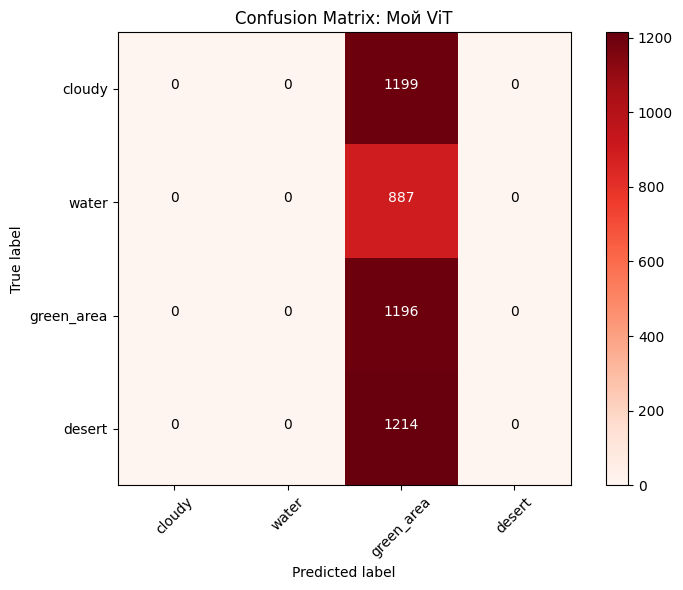

In [29]:
classes = get_classes(data_dir)
classification_report_model(trained_model, train_loader, device, classes, "Мой ViT")

# Выводы
для CNN улучшение бейслайна крайне положительно сказалось, и два из 4 класса он идельано классифицирует

однако для трансформера своего написания как бы я не старалась, за пределы 30% точность не уходит. Я добалвляла и эпохи, и доп. слои и предварительную свертку, однако видимо дело в неудачной реализации